# LSTM Implementation and Experiments

This notebook demonstrates the LSTM implementation and experiments. We'll work with the NusaX-Sentiment dataset to perform text classification.

In [54]:
%load_ext autoreload
%autoreload 2

import sys
import os

sys.path.append('../..')

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense, Bidirectional
from sklearn.metrics import f1_score, classification_report

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [55]:
from src.models.src.models.lstm.nusax_loader import NusaXLoader
from src.models.src.models.lstm.experiments import LSTMExperiments
from src.models.src.models.lstm.lstm_model import LSTMModel
from src.models.src.models.lstm.lstm_layer import LSTMLayer
from src.models.src.models.lstm.embedding_layer import EmbeddingLayer
from src.models.src.models.base_model.layers.dense_layer import DenseLayer
from src.models.src.models.base_model.layers.dropout_layer import DropoutLayer
from src.models.src.models.base_model.layers.activation_layer import Softmax
from src.models.src.models.base_model.utils.evaluation import compare_keras_vs_scratch
from src.models.src.models.base_model.utils.visualization import plot_training_history

In [56]:
# MacOS GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Set memory growth to True
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(f"Num GPUs Available: {len(gpus)}")
        print(f"Num Logical GPUs: {len(logical_gpus)}")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)


Num GPUs Available: 1
Num Logical GPUs: 1


## 1. Load Data

In [57]:
# Initialize the data loader
data_loader = NusaXLoader(batch_size=32)

# Train
train_dataset = data_loader.get_dataset('train')
for tokens, labels in train_dataset.take(1):
    sample_tokens = tokens.numpy()
    sample_labels = labels.numpy()
    break

# Get vocabulary
vocab = data_loader.get_vocabulary()
print(f"Vocabulary size: {len(vocab)}")
print(f"First 20 words in vocabulary: {vocab[:20]}")

# Decode a few examples
print("\nSample texts:")
for i in range(3):
    # Convert token IDs back to words
    words = [vocab[idx] if idx < len(vocab) else "[UNK]" for idx in sample_tokens[i] if idx > 0]
    text = " ".join(words)
    print(f"Text {i+1}: {text}")
    print(f"Label: {sample_labels[i]}\n")

Vocabulary size: 2836
First 20 words in vocabulary: ['', '[UNK]', 'yang', 'di', 'dan', 'tidak', 'saya', 'dengan', 'enak', 'ini', 'makan', 'untuk', 'ke', 'tempat', 'makanan', 'juga', 'sangat', 'ada', 'banyak', 'karena']

Sample texts:
Text 1: nikmati cicilan 0 hingga 12 bulan untuk pemesanan tiket pesawat air asia dengan kartu kredit bni
Label: 1

Text 2: kuekue yang disajikan bikin saya bernostalgia semuanya tipikal kue zaman dulu baik dari penampilan maupun rasa kuenya enak dan harganya juga murah
Label: 2

Text 3: ibu pernah bekerja di grab indonesia
Label: 1



## 2. Hyperparameter Experiments with LSTM

In [58]:
experiments = LSTMExperiments(data_loader=data_loader,batch_size=32, epochs=10, embedding_dim=100)

Vocabulary size: 2836
Number of classes: 3
Maximum sequence length: 100
Batch size: 32
Epochs: 10
Embedding dimension: 100


### 2.1 Experiment: Number of LSTM Layers


=== Training model with 1 LSTM Layer ===
Epoch 1/10


/Users/dewo/Documents/informatics/repositories/college/semester-6/ml/Tubes2_ML/venv/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.4164 - loss: 1.0859 - val_accuracy: 0.3800 - val_loss: 1.0852
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.3429 - loss: 1.0945 - val_accuracy: 0.3800 - val_loss: 1.0784
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.3396 - loss: 1.0797 - val_accuracy: 0.3800 - val_loss: 1.0783
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.3150 - loss: 1.0842 - val_accuracy: 0.3800 - val_loss: 1.0782
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.3449 - loss: 1.0814 - val_accuracy: 0.3800 - val_loss: 1.0782
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.3542 - loss: 1.0812 - val_accuracy: 0.3800 - val_loss: 1.0782
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.3410 - loss: 1.0845 - val_accuracy: 0.3800 - val_loss: 1.0782
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.3487 - loss: 1.0843 - val_accuracy: 0.3800 - val_loss: 1.

Model: "sequential_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_33 (Embedding)        │ (None, 100, 100)       │       283,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_45 (LSTM)                  │ (None, 128)            │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_45 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,203,707 (4.59 MB)

 Trainable params: 401,235 (1.53 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 802,472 (3.06 MB)


=== Training model with 2 LSTM Layers ===
Epoch 1/10


/Users/dewo/Documents/informatics/repositories/college/semester-6/ml/Tubes2_ML/venv/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 0.4111 - loss: 1.0883 - val_accuracy: 0.3800 - val_loss: 1.0893
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.3299 - loss: 1.0999 - val_accuracy: 0.3800 - val_loss: 1.0780
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.4045 - loss: 1.0808 - val_accuracy: 0.3800 - val_loss: 1.0783
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.3375 - loss: 1.0852 - val_accuracy: 0.3800 - val_loss: 1.0785
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.3958 - loss: 1.0808 - val_accuracy: 0.3800 - val_loss: 1.0785
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.3171 - loss: 1.0852 - val_accuracy: 0.3800 - val_loss: 1.0788
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.3711 - loss: 1.0835 - val_accuracy: 0.3800 - val_loss: 1.0781
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.3497 - loss: 1.0807 - val_accuracy: 0.3800 - val_loss: 1.

Model: "sequential_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_34 (Embedding)        │ (None, 100, 100)       │       283,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_46 (LSTM)                  │ (None, 100, 128)       │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_46 (Dropout)            │ (None, 100, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_47 (LSTM)                  │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_47 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,351,355 (5.16 MB)

 Trainable params: 450,451 (1.72 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 900,904 (3.44 MB)


=== Training model with 3 LSTM Layers ===
Epoch 1/10


/Users/dewo/Documents/informatics/repositories/college/semester-6/ml/Tubes2_ML/venv/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - accuracy: 0.4188 - loss: 1.0910 - val_accuracy: 0.3800 - val_loss: 1.0914
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.3454 - loss: 1.1019 - val_accuracy: 0.3800 - val_loss: 1.0779
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.3362 - loss: 1.0801 - val_accuracy: 0.3800 - val_loss: 1.0782
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.3120 - loss: 1.0857 - val_accuracy: 0.3800 - val_loss: 1.0782
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.3512 - loss: 1.0834 - val_accuracy: 0.3800 - val_loss: 1.0780
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.3409 - loss: 1.0848 - val_accuracy: 0.3800 - val_loss: 1.0787
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.3589 - loss: 1.0833 - val_accuracy: 0.3800 - val_loss: 1.0782
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.3581 - loss: 1.0826 - val_accuracy: 0.3800 - val_loss: 1

Model: "sequential_35"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_35 (Embedding)        │ (None, 100, 100)       │       283,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_48 (LSTM)                  │ (None, 100, 128)       │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_48 (Dropout)            │ (None, 100, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_49 (LSTM)                  │ (None, 100, 64)        │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_49 (Dropout)            │ (None, 100, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_50 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_50 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,388,315 (5.30 MB)

 Trainable params: 462,771 (1.77 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 925,544 (3.53 MB)

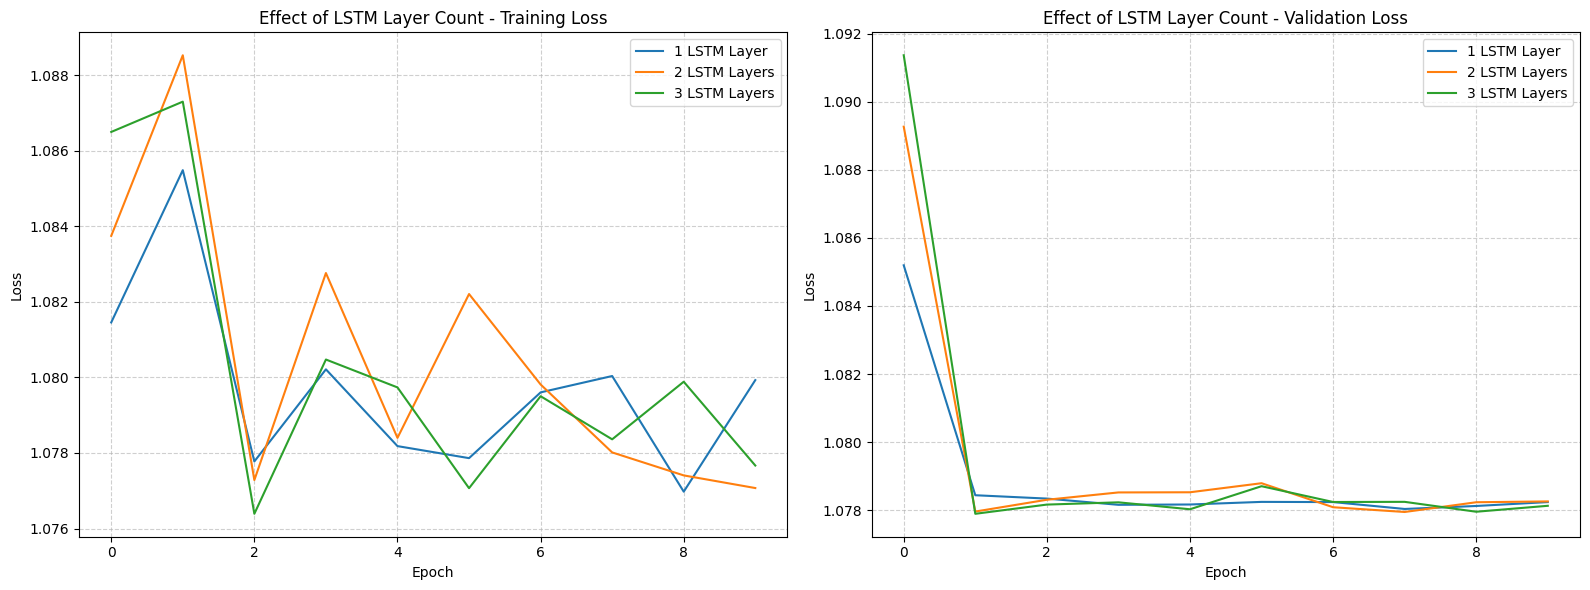

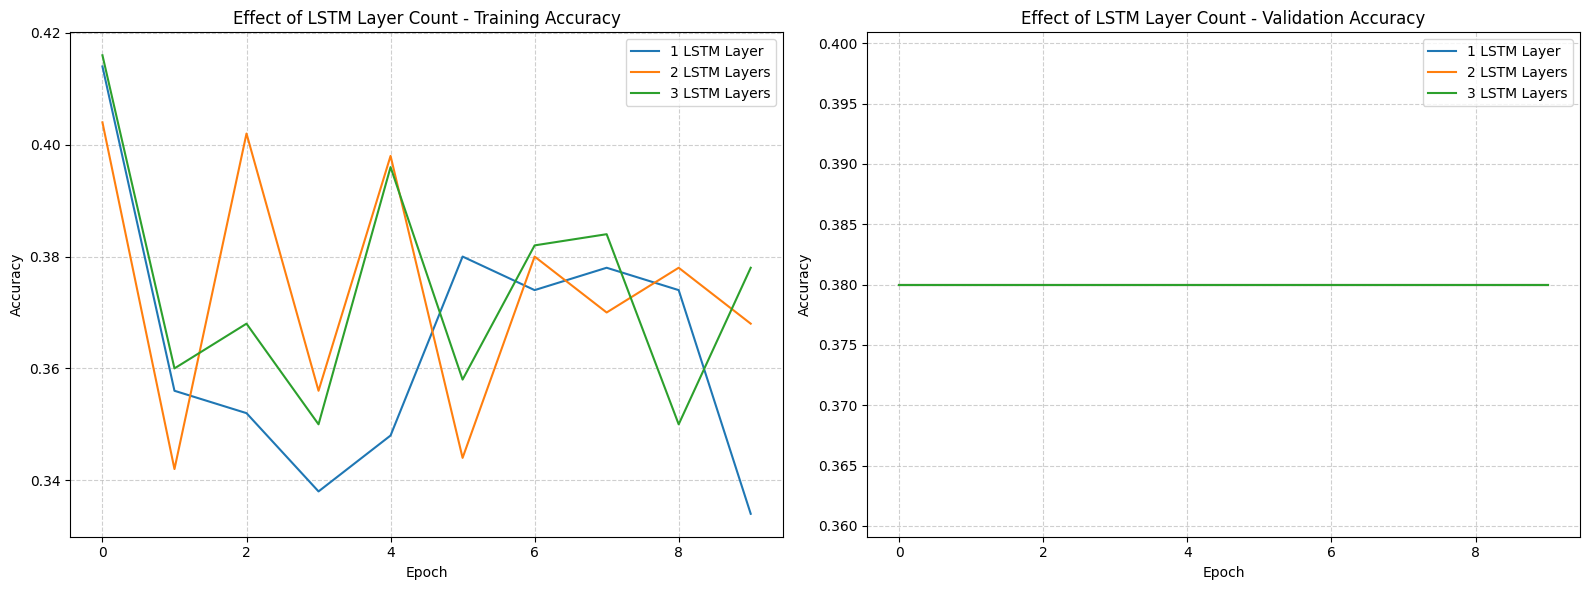

In [59]:
# Define variants for number of LSTM layers
layer_count_variants = [
    (1, "1 LSTM Layer"),
    (2, "2 LSTM Layers"),
    (3, "3 LSTM Layers")
]

# Run experiment
layer_count_models, layer_count_histories = experiments.run_layer_count_experiment(layer_count_variants)

### 2.2 Experiment: Number of LSTM Cells per Layer


=== Training model with 64 Cells ===
Epoch 1/10


/Users/dewo/Documents/informatics/repositories/college/semester-6/ml/Tubes2_ML/venv/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.4356 - loss: 1.0867 - val_accuracy: 0.3800 - val_loss: 1.0802
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.3432 - loss: 1.0881 - val_accuracy: 0.3800 - val_loss: 1.0782
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.3478 - loss: 1.0816 - val_accuracy: 0.3800 - val_loss: 1.0781
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.3555 - loss: 1.0806 - val_accuracy: 0.3800 - val_loss: 1.0781
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.3414 - loss: 1.0838 - val_accuracy: 0.3800 - val_loss: 1.0783
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.3860 - loss: 1.0772 - val_accuracy: 0.3800 - val_loss: 1.0787
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.3619 - loss: 1.0850 - val_accuracy: 0.3800 - val_loss: 1.0781
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.3616 - loss: 1.0826 - val_accuracy: 0.3800 - val_loss: 1.

Model: "sequential_36"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_36 (Embedding)        │ (None, 100, 100)       │       283,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_51 (LSTM)                  │ (None, 64)             │        42,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_51 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 978,107 (3.73 MB)

 Trainable params: 326,035 (1.24 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 652,072 (2.49 MB)


=== Training model with 128 Cells ===
Epoch 1/10


/Users/dewo/Documents/informatics/repositories/college/semester-6/ml/Tubes2_ML/venv/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.3895 - loss: 1.0880 - val_accuracy: 0.3800 - val_loss: 1.0855
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.3491 - loss: 1.0938 - val_accuracy: 0.3800 - val_loss: 1.0781
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.3672 - loss: 1.0801 - val_accuracy: 0.3800 - val_loss: 1.0782
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.3520 - loss: 1.0820 - val_accuracy: 0.3800 - val_loss: 1.0782
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.3646 - loss: 1.0810 - val_accuracy: 0.3800 - val_loss: 1.0782
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.3370 - loss: 1.0843 - val_accuracy: 0.3800 - val_loss: 1.0781
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.3564 - loss: 1.0802 - val_accuracy: 0.3800 - val_loss: 1.0783
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.3437 - loss: 1.0833 - val_accuracy: 0.3800 - val_loss: 1.

Model: "sequential_37"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_37 (Embedding)        │ (None, 100, 100)       │       283,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_52 (LSTM)                  │ (None, 128)            │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_52 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,203,707 (4.59 MB)

 Trainable params: 401,235 (1.53 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 802,472 (3.06 MB)


=== Training model with 256 Cells ===
Epoch 1/10


/Users/dewo/Documents/informatics/repositories/college/semester-6/ml/Tubes2_ML/venv/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.3998 - loss: 1.0907 - val_accuracy: 0.3800 - val_loss: 1.0883
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.3430 - loss: 1.0959 - val_accuracy: 0.3800 - val_loss: 1.0779
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.3642 - loss: 1.0811 - val_accuracy: 0.3800 - val_loss: 1.0786
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.3367 - loss: 1.0834 - val_accuracy: 0.3800 - val_loss: 1.0786
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.3259 - loss: 1.0849 - val_accuracy: 0.3800 - val_loss: 1.0780
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.3523 - loss: 1.0826 - val_accuracy: 0.3800 - val_loss: 1.0783
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.3400 - loss: 1.0837 - val_accuracy: 0.3800 - val_loss: 1.0782
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.3348 - loss: 1.0836 - val_accuracy: 0.3800 - val_loss: 1.

Model: "sequential_38"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_38 (Embedding)        │ (None, 100, 100)       │       283,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_53 (LSTM)                  │ (None, 256)            │       365,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_53 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,949,819 (7.44 MB)

 Trainable params: 649,939 (2.48 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,299,880 (4.96 MB)

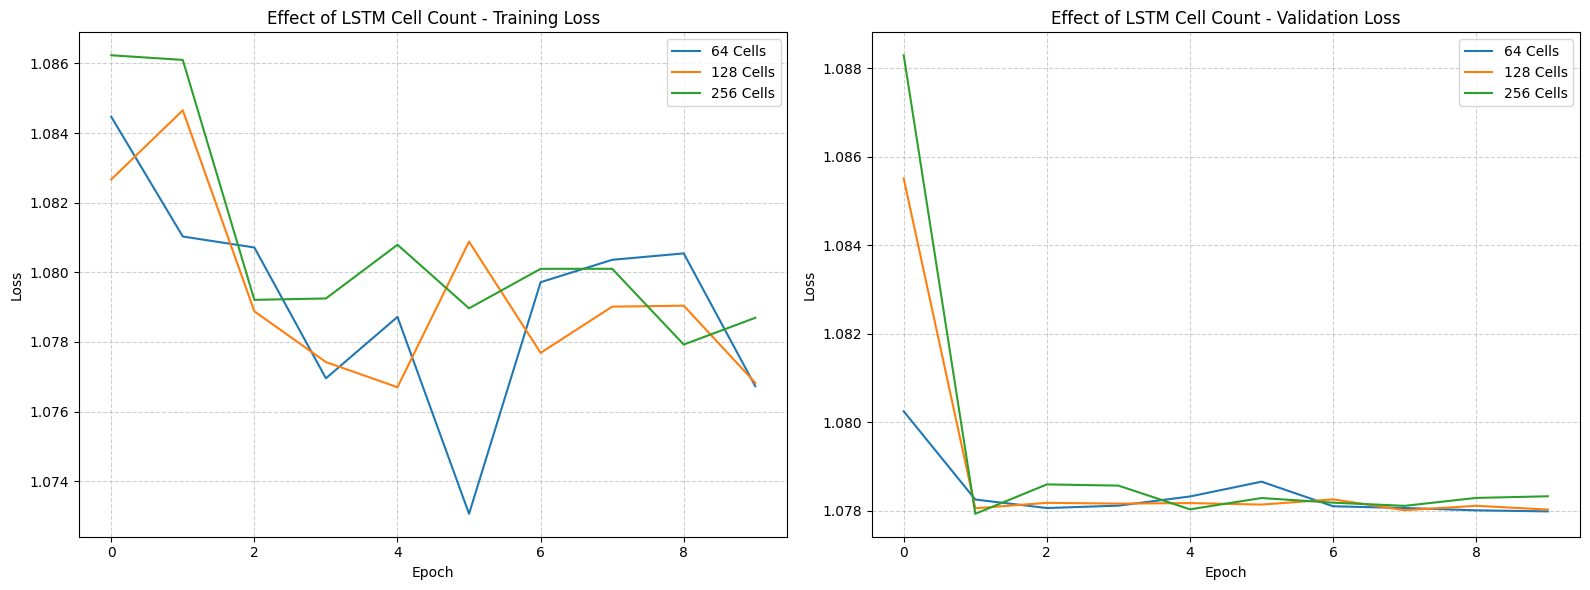

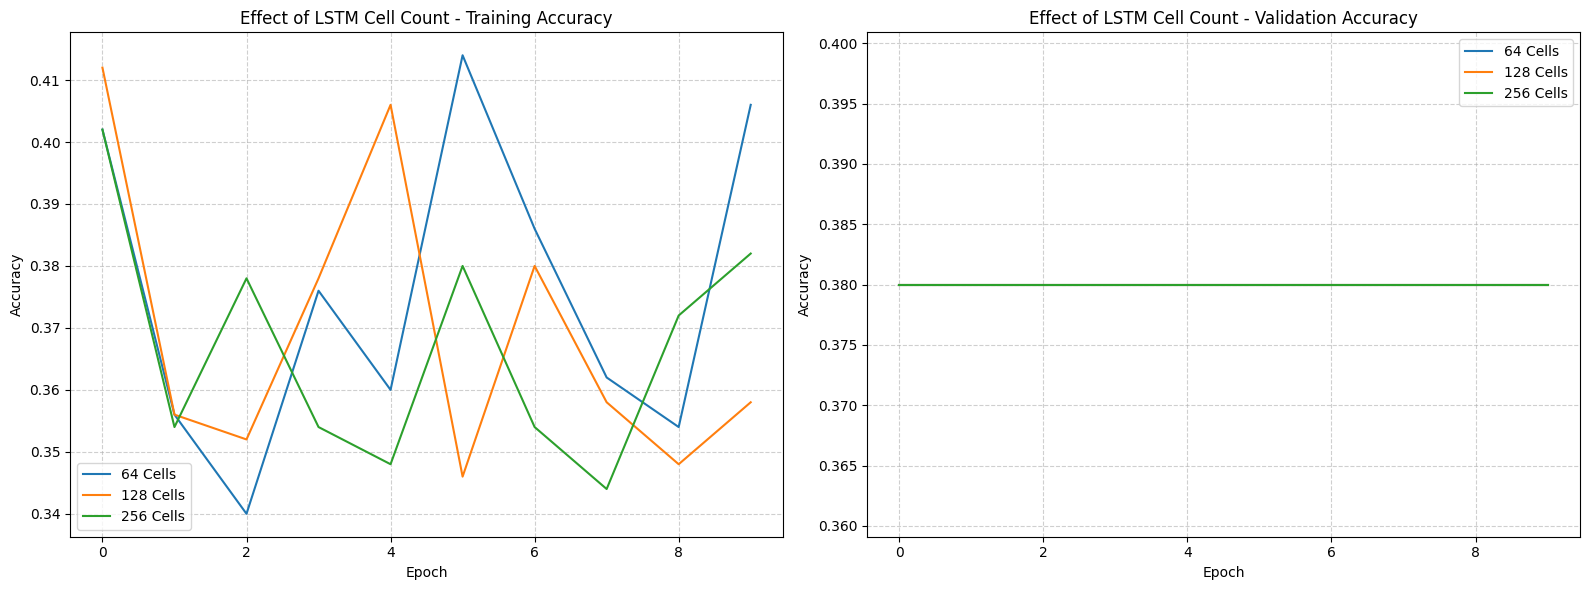

In [60]:
# Define variants for cell counts
cell_count_variants = [
    ([64], "64 Cells"),
    ([128], "128 Cells"),
    ([256], "256 Cells")
]

# Run experiment
cell_count_models, cell_count_histories = experiments.run_cell_count_experiment(cell_count_variants)


### 2.3 Experiment: LSTM Direction


=== Training model with Unidirectional LSTM ===
Epoch 1/10


/Users/dewo/Documents/informatics/repositories/college/semester-6/ml/Tubes2_ML/venv/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.4093 - loss: 1.0889 - val_accuracy: 0.3800 - val_loss: 1.0828
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.3563 - loss: 1.0902 - val_accuracy: 0.3800 - val_loss: 1.0784
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.3678 - loss: 1.0812 - val_accuracy: 0.3800 - val_loss: 1.0782
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.3462 - loss: 1.0840 - val_accuracy: 0.3800 - val_loss: 1.0780
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.3345 - loss: 1.0813 - val_accuracy: 0.3800 - val_loss: 1.0783
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.3566 - loss: 1.0813 - val_accuracy: 0.3800 - val_loss: 1.0780
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.3481 - loss: 1.0817 - val_accuracy: 0.3800 - val_loss: 1.0782
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.3504 - loss: 1.0801 - val_accuracy: 0.3800 - val_loss: 1.

Model: "sequential_39"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_39 (Embedding)        │ (None, 100, 100)       │       283,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_54 (LSTM)                  │ (None, 128)            │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_54 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,203,707 (4.59 MB)

 Trainable params: 401,235 (1.53 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 802,472 (3.06 MB)


=== Training model with Bidirectional LSTM ===
Epoch 1/10


/Users/dewo/Documents/informatics/repositories/college/semester-6/ml/Tubes2_ML/venv/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - accuracy: 0.4308 - loss: 1.0766 - val_accuracy: 0.5400 - val_loss: 1.0168
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.5429 - loss: 0.9470 - val_accuracy: 0.5500 - val_loss: 0.9321
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.6346 - loss: 0.7565 - val_accuracy: 0.6200 - val_loss: 0.8159
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.7561 - loss: 0.5264 - val_accuracy: 0.6700 - val_loss: 0.8625
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9130 - loss: 0.2909 - val_accuracy: 0.7100 - val_loss: 0.7556
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9847 - loss: 0.1231 - val_accuracy: 0.7100 - val_loss: 0.8092
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9851 - loss: 0.0832 - val_accuracy: 0.7300 - val_loss: 0.8453
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9987 - loss: 0.0231 - val_accuracy: 0.7300 - val_loss: 0.

Model: "sequential_40"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_40 (Embedding)        │ (None, 100, 100)       │       283,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 256)            │       234,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_55 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,556,603 (5.94 MB)

 Trainable params: 518,867 (1.98 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,037,736 (3.96 MB)

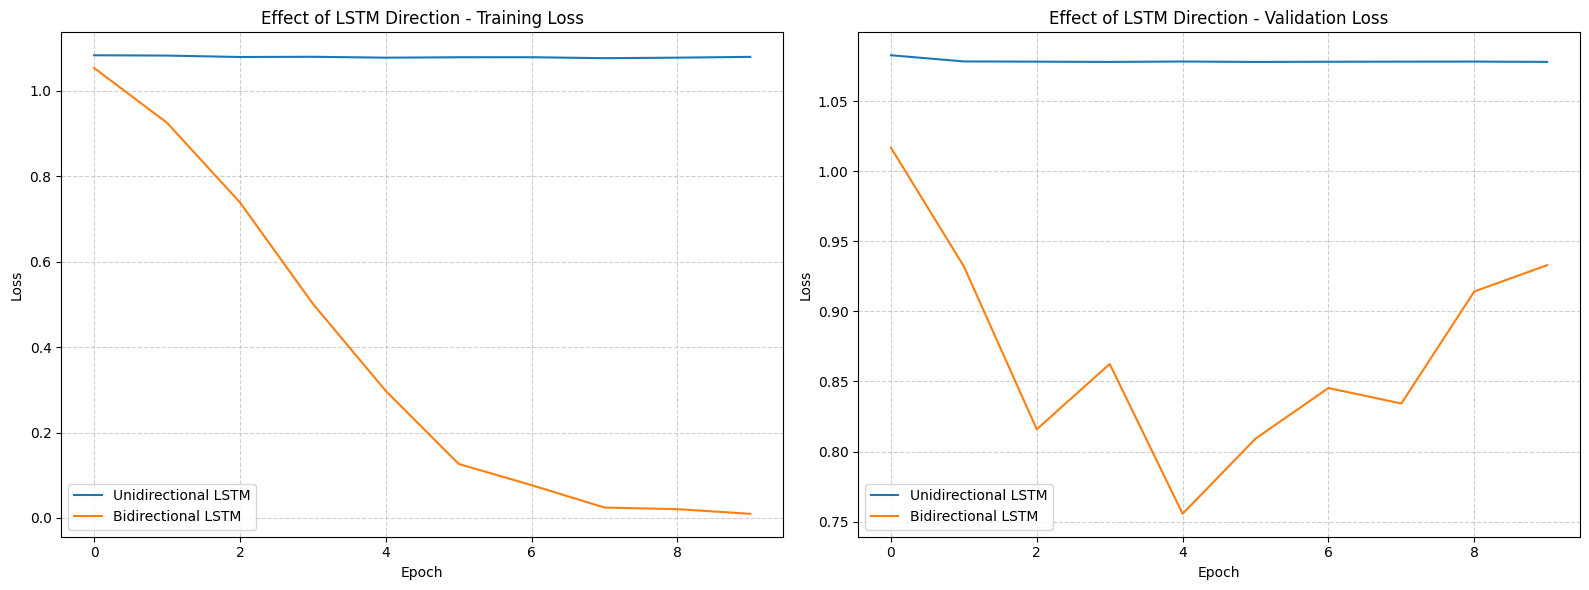

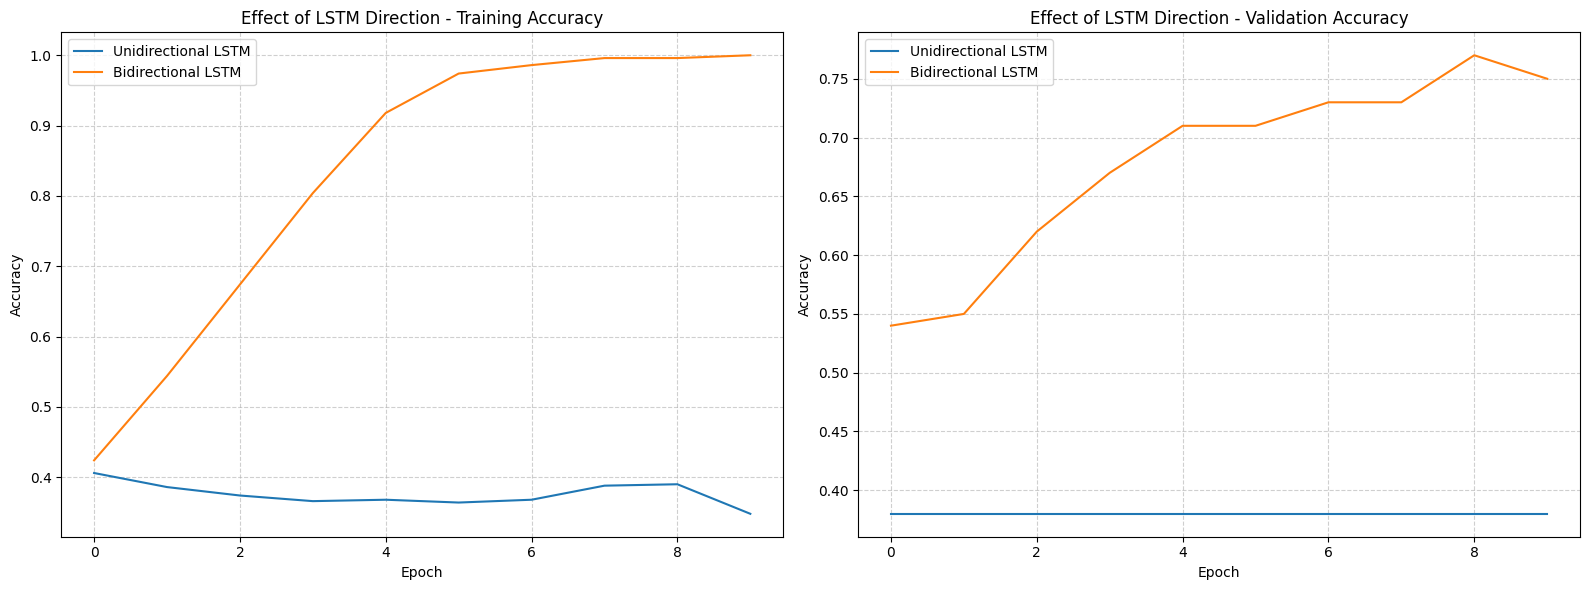

In [61]:
# Define variants for LSTM direction
direction_variants = [
    (False, "Unidirectional LSTM"),
    (True, "Bidirectional LSTM")
]

# Run experiment
direction_models, direction_histories = experiments.run_direction_experiment(direction_variants)


## 3. From-Scratch LSTM Implementation

In [62]:
# Choose one of the trained models (e.g., from the bidirectional experiment)
keras_model = direction_models[1][0]  # Bidirectional LSTM model

# Summary of the chosen model
keras_model.summary()

# Save the model weights
keras_model.save_weights('lstm_model.weights.h5')

Model: "sequential_40"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_40 (Embedding)        │ (None, 100, 100)       │       283,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 256)            │       234,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_55 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,556,603 (5.94 MB)

 Trainable params: 518,867 (1.98 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,037,736 (3.96 MB)

In [63]:
# Get embedding dimension and vocabulary size
embedding_dim = 100
vocab_size = len(data_loader.get_vocabulary())
hidden_dim = 128
num_classes = data_loader.num_classes
sequence_length = data_loader.max_sequence_length

# Create a from-scratch LSTM model that matches the Keras model
scratch_model = LSTMModel()

# Add layers corresponding to the Keras model architecture
scratch_model.add(EmbeddingLayer(input_dim=vocab_size, output_dim=embedding_dim))
scratch_model.add(LSTMLayer(input_dim=embedding_dim, hidden_dim=hidden_dim, bidirectional=True))
scratch_model.add(DropoutLayer(dropout_rate=0.2))
scratch_model.add(DenseLayer(input_dim=hidden_dim*2, output_dim=num_classes, activation=Softmax()))

# Load weights from the Keras model
scratch_model.load_weights_from_keras(keras_model)

print("Weights loaded from Keras model to from-scratch implementation.")

Weights loaded from Keras model to from-scratch implementation.


In [64]:
# Get test data
x_test, y_test = data_loader.get_vectorized_data('test')

# Compare predictions
comparison = compare_keras_vs_scratch(keras_model, scratch_model, x_test, y_test, batch_size=32)

print("\nKeras Model Metrics:")
print(f"Accuracy: {comparison['keras_metrics']['accuracy']:.4f}")
print(f"Macro F1-Score: {comparison['keras_metrics']['macro_f1']:.4f}")

print("\nFrom-Scratch Model Metrics:")
print(f"Accuracy: {comparison['scratch_metrics']['accuracy']:.4f}")
print(f"Macro F1-Score: {comparison['scratch_metrics']['macro_f1']:.4f}")

print(f"\nModel Agreement: {comparison['model_agreement']:.4f}")


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

Keras Model Metrics:
Accuracy: 0.7350
Macro F1-Score: 0.7206

From-Scratch Model Metrics:
Accuracy: 0.7325
Macro F1-Score: 0.7197

Model Agreement: 0.9875


In [65]:
# Get a few test samples
num_samples = 5
sample_indices = np.random.choice(x_test.shape[0], num_samples, replace=False)
sample_texts = x_test[sample_indices]
sample_labels = y_test[sample_indices]

# Make predictions with both models
keras_preds = np.argmax(keras_model.predict(sample_texts), axis=1)
scratch_preds = scratch_model.predict(sample_texts)

# Define sentiment labels
sentiment_labels = ["Negative", "Neutral", "Positive"]

# Visualize the results
for i in range(num_samples):
    # Convert token IDs back to words
    words = [vocab[idx] if idx < len(vocab) else "[UNK]" for idx in sample_texts[i] if idx > 0]
    text = " ".join(words)
    
    # Show true label and predictions
    keras_correct = keras_preds[i] == sample_labels[i]
    scratch_correct = scratch_preds[i] == sample_labels[i]
    
    print(f"\nText: {text[:100]}{'...' if len(text) > 100 else ''}")
    print(f"True sentiment: {sentiment_labels[sample_labels[i]]}")
    print(f"Keras prediction: {sentiment_labels[keras_preds[i]]} {'✓' if keras_correct else '✗'}")
    print(f"Scratch prediction: {sentiment_labels[scratch_preds[i]]} {'✓' if scratch_correct else '✗'}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step

Text: sebuah [UNK] baru saja [UNK] kampung [UNK] di [UNK] [UNK] [UNK] [UNK] yang terjadi pada senin 13 8 s...
True sentiment: Neutral
Keras prediction: Neutral ✓
Scratch prediction: Neutral ✓

Text: makanan sudah oke namun untuk penataan tempat duduk kurang terlihat terlalu ramai sehingga tidak nya...
True sentiment: Negative
Keras prediction: Negative ✓
Scratch prediction: Negative ✓

Text: bus harapan [UNK] jauh lebih nyaman dibandingkan yang lainnya
True sentiment: Positive
Keras prediction: Negative ✗
Scratch prediction: Negative ✗

Text: minta informasi tentang daftar harga [UNK] yang sedang [UNK]
True sentiment: Neutral
Keras prediction: Negative ✗
Scratch prediction: Negative ✗

Text: kami mengunjungi tempat ini karena lokasinya yang [UNK] dengan tempat kami menginap kami memesan nas...
True sentiment: Positive
Keras prediction: Positive ✓
Scratch prediction: Positive ✓
